In [37]:
import scanpy as sc
import numpy as np
import pandas as pd
import torch 
import matplotlib.pyplot as plt
import seaborn as sns
from celldreamer.paths import ROOT, DATA_DIR

In [38]:
cd $ROOT

/nfs/homedirs/pala/celldreamer


In [39]:
adata = sc.read_h5ad(DATA_DIR / 'sciplex' / 'sciplex_complete_middle_subset.h5ad')

In [42]:
# X_unnorm = np.exp(adata.X.A)-1
X_unnorm = adata.X.A

In [43]:
X_unnorm.var(0).max()

0.81976795

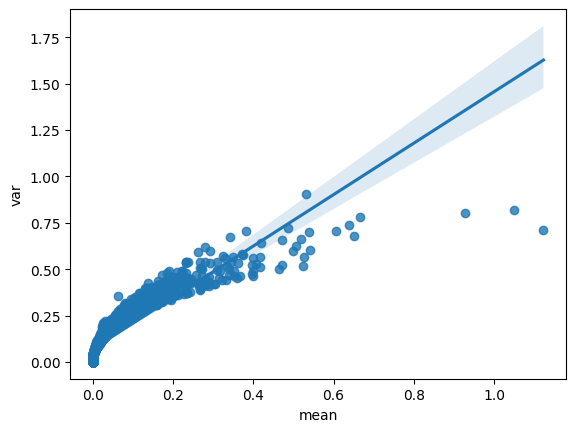

In [44]:
# plt.scatter(adata.X.A.mean(1), adata.X.A.var(1))
sns.regplot(x="mean", y="var", data=pd.DataFrame({"mean":X_unnorm.mean(0), 
                                                 "var": X_unnorm.std(0)}));

**Util functions**

In [5]:
def assemble_adata(X, obs):
    adata_tmp = sc.AnnData(X=X,
                        obs=obs)
    sc.tl.pca(adata_tmp)
    sc.pp.neighbors(adata_tmp)
    sc.tl.umap(adata_tmp)
    return adata_tmp

**Exploration**

In [6]:
np.max(adata.X.A)

In [7]:
np.min(adata.X.A)

In [8]:
sc.pl.umap(adata, color="cell_type")

In [ ]:
sc.pl.umap(adata[adata.obs.cell_type=="MCF7"], color="pathway")

In [ ]:
adata.obs.cov_drug.value_counts()

**Check how the forward diffusion process behaves with counts**

In [ ]:
from celldreamer.models.diffusion.distributions import x0_to_xt
from celldreamer.models.diffusion.variance_scheduler.cosine import CosineScheduler 

In [ ]:
var_scheduler = CosineScheduler(T=4000)

alphas_hat = var_scheduler.get_alpha_hat()
alphas = var_scheduler.get_alphas()
betas = var_scheduler.get_betas()
betas_hat = var_scheduler.get_betas_hat()

In [ ]:
alphas_hat[-1]

In [ ]:
adata_small = adata.copy()
sc.pp.subsample(adata_small, fraction=0.05)
# adata_small.X -= adata_small.X.mean(1)
# adata_small.X /= adata_small.X.std(1)
# adata_small = assemble_adata(adata_small.X.A, adata_small.obs)

In [ ]:
adata_small.X.max()

In [ ]:
sc.pl.umap(adata_small, color="cell_type")

In [ ]:
X = torch.tensor(adata_small.X.A)
eps = torch.rand_like(X)
X_t = x0_to_xt(X, alphas_hat[-1], eps)  

In [ ]:
X_t.max()

In [ ]:
adata_small_noise = assemble_adata(X_t.cpu().numpy(), adata_small.obs)

In [ ]:
sc.pl.umap(adata_small_noise, color="cell_type")

**Check if obtained counts are Gaussian**

In [ ]:
# Generate random noise 
X_eps = np.random.rand(adata_small.X.shape[0], adata_small.X.shape[1])

In [ ]:
X_noise_real_generated = np.vstack([adata_small_noise.X, X_eps])
noise_label = ["fake_noise"]*adata_small_noise.X.shape[0] + ["real_noise"]*adata_small_noise.X.shape[0]
obs_noise_stack = pd.DataFrame({"noise_label":noise_label})

In [ ]:
adata_small_noise_real_generated = assemble_adata(X_noise_real_generated, obs_noise_stack)

In [ ]:
sc.pl.pca(adata_small_noise_real_generated, color="noise_label")

**Check if preserved normalization**

In [27]:
adata_small = adata.copy()
sc.pp.subsample(adata_small, fraction=0.05)

In [31]:
adata_small.X = np.exp(adata_small.X.A)-1

In [33]:
sc.tl.pca(adata_small)
sc.pp.neighbors(adata_small)
sc.tl.umap(adata_small)


/nfs/staff-ssd/pala/envs/celldreamer/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/nfs/staff-ssd/pala/envs/celldreamer/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/nfs/staff-ssd/pala/envs/celldreamer/lib/python3.10/site-packages/

NameError: name 'asdata_small' is not defined

/nfs/staff-ssd/pala/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


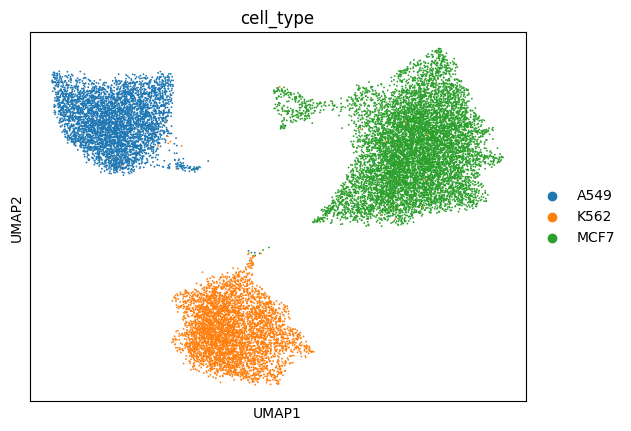

In [36]:
sc.pl.umap(adata_small, color="cell_type")